In [1]:
from stylegan2.models import Generator
import torch
import numpy as np
import matplotlib.pyplot as plt

config = {"latent" : 512, "n_mlp" : 8, "channel_multiplier": 2}
generator = Generator(
        size= 1024,
        style_dim=config["latent"],
        n_mlp=config["n_mlp"],
        channel_multiplier=config["channel_multiplier"]
    )

generator.load_state_dict(torch.load("./pretrained/stylegan2-ffhq-config-f.pt")['g_ema'])
generator.eval()
generator.cuda()

Generator(
  (style): Sequential(
    (0): PixelNorm()
    (1): EqualLinear(512, 512)
    (2): EqualLinear(512, 512)
    (3): EqualLinear(512, 512)
    (4): EqualLinear(512, 512)
    (5): EqualLinear(512, 512)
    (6): EqualLinear(512, 512)
    (7): EqualLinear(512, 512)
    (8): EqualLinear(512, 512)
  )
  (input): ConstantInput()
  (conv1): StyledConv(
    (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
    (noise): NoiseInjection()
    (activate): FusedLeakyReLU()
  )
  (to_rgb1): ToRGB(
    (conv): ModulatedConv2d(512, 3, 1, upsample=False, downsample=False)
  )
  (convs): ModuleList(
    (0): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=True, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (1): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (2): StyledConv(
      (conv): Modul

In [4]:
from torch.nn import functional as F

index = [0,1,1,2,2,3,4,4,5,6,6,7,8,8,9,10,10,11,12,12,13,14,14,15,16,16]

def conv_warper(layer, input, style, noise):
    # the conv should change
    conv = layer.conv
    batch, in_channel, height, width = input.shape

    style = style.view(batch, 1, in_channel, 1, 1)
    weight = conv.scale * conv.weight * style

    if conv.demodulate:
        demod = torch.rsqrt(weight.pow(2).sum([2, 3, 4]) + 1e-8)
        weight = weight * demod.view(batch, conv.out_channel, 1, 1, 1)

    weight = weight.view(
        batch * conv.out_channel, in_channel, conv.kernel_size, conv.kernel_size
    )

    if conv.upsample:
        input = input.view(1, batch * in_channel, height, width)
        weight = weight.view(
            batch, conv.out_channel, in_channel, conv.kernel_size, conv.kernel_size
        )
        weight = weight.transpose(1, 2).reshape(
            batch * in_channel, conv.out_channel, conv.kernel_size, conv.kernel_size
        )
        out = F.conv_transpose2d(input, weight, padding=0, stride=2, groups=batch)
        _, _, height, width = out.shape
        out = out.view(batch, conv.out_channel, height, width)
        out = conv.blur(out)

    elif conv.downsample:
        input = conv.blur(input)
        _, _, height, width = input.shape
        input = input.view(1, batch * in_channel, height, width)
        out = F.conv2d(input, weight, padding=0, stride=2, groups=batch)
        _, _, height, width = out.shape
        out = out.view(batch, conv.out_channel, height, width)

    else:
        input = input.view(1, batch * in_channel, height, width)
        out = F.conv2d(input, weight, padding=conv.padding, groups=batch)
        _, _, height, width = out.shape
        out = out.view(batch, conv.out_channel, height, width)
        
    out = layer.noise(out, noise=noise)
    out = layer.activate(out)
    
    return out

def decoder(G, style_space, latent, noise):
    # an decoder warper for G
    out = G.input(latent)
    out = conv_warper(G.conv1, out, style_space[0], noise[0])
    skip = G.to_rgb1(out, latent[:, 1])

    i = 1
    for conv1, conv2, noise1, noise2, to_rgb in zip(
        G.convs[::2], G.convs[1::2], noise[1::2], noise[2::2], G.to_rgbs
    ):
        out = conv_warper(conv1, out, style_space[i], noise=noise1)
        out = conv_warper(conv2, out, style_space[i+1], noise=noise2)
        skip = to_rgb(out, latent[:, i + 2], skip)

        i += 2

    image = skip

    return image

def encoder(G, noise):
    # an encoder warper for G
    styles = [noise]
    style_space = []
    
    styles = [G.style(s) for s in styles]
    noise = [getattr(G.noises, 'noise_{}'.format(i)) for i in range(G.num_layers)]
    inject_index = G.n_latent
    latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
    style_space.append(G.conv1.conv.modulation(latent[:, 0]))

    i = 1
    for conv1, conv2, noise1, noise2, to_rgb in zip(
        G.convs[::2], G.convs[1::2], noise[1::2], noise[2::2], G.to_rgbs
    ):
        style_space.append(conv1.conv.modulation(latent[:, i]))
        style_space.append(conv2.conv.modulation(latent[:, i+1]))
        i += 2
        
    return style_space, latent, noise

In [5]:
def visual(output):
    output = (output + 1)/2
    output = torch.clamp(output, 0, 1)
    if output.shape[1] == 1:
        output = torch.cat([output, output, output], 1)
    output = output[0].detach().cpu().permute(1,2,0).numpy()
    output = (output*255).astype(np.uint8)
    plt.imshow(output)
    plt.show()

# Demo

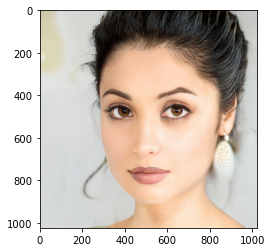

In [6]:
test_input = torch.randn(1,512).cuda()

output, _ = generator([test_input], False)
visual(output)

In [7]:
# for 9_409 in the paper, you should have "style_space[index[9]][:, 409]"
# the value to shift is hand-craft

In [9]:
# eye
style_space, latent, noise = encoder(generator, test_input)
style_space[index[9]][:, 409] += 10
image = decoder(generator, style_space, latent, noise)
visual(image)

In [14]:
# hair
style_space, latent, noise = encoder(generator, test_input)
style_space[index[12]][:, 330] -= 50
image = decoder(generator, style_space, latent, noise)
visual(image)

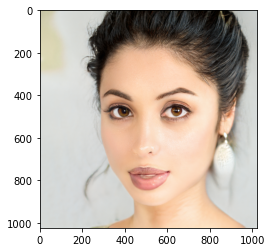

In [16]:
# mouth
style_space, latent, noise = encoder(generator, test_input)
style_space[index[6]][:, 259] -= 20
image = decoder(generator, style_space, latent, noise)
visual(image)

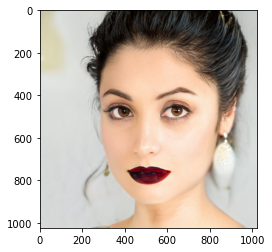

In [19]:
# lip
style_space, latent, noise = encoder(generator, test_input)
style_space[index[15]][:, 45] -= 3
image = decoder(generator, style_space, latent, noise)
visual(image)